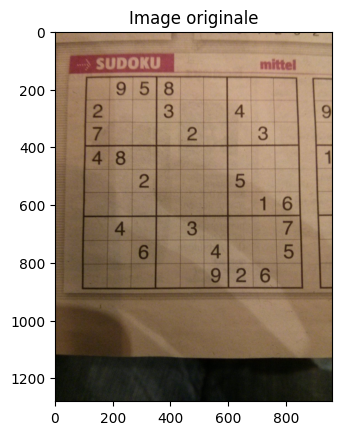

In [343]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# image_path = "c:\Image_save\sudoku_capture_2025-05-20_14-07-33.png"  # Il faut remplacer par la nouvelle image que tu veux tester
image_path = "v1_training/image/image1006.jpg"  # Il faut remplacer par la nouvelle image que tu veux tester
image = cv2.imread(image_path)
# Afficher l'image originale 
plt.figure()
plt.title("Image originale")
# Convertir l'image en RGB pour l'affichage avec matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


In [344]:
# import os
# import ipywidgets as widgets
# from IPython.display import display

# # 📂 Récupérer les fichiers images du dossier
# folder = "v1_training/image"
# image_files = sorted([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# # 📌 Création du dropdown
# dropdown = widgets.Dropdown(
#     options=image_files,
#     description='Image:',
#     layout=widgets.Layout(width='300px')
# )

# # 👁️ Afficher le menu
# display(dropdown)


In [345]:
# selected_file = dropdown.value
# img_path = os.path.join(folder, selected_file)

# # Lecture et affichage
# image = cv2.imread(img_path)
# plt.figure()
# plt.title(f"Image sélectionnée : {selected_file}")
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()


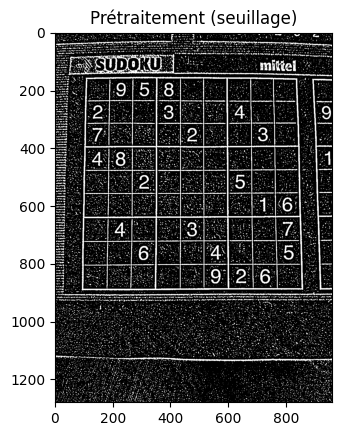

In [ ]:
# Fonction de prétraitement de l'image
def pretraitement(image):
    # Convertit l'image en niveaux de gris pour simplifier le traitement.
    gris = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #Réduit les petits bruits ou variations (comme les ombres ou pixels isolés).
    blur = cv2.GaussianBlur(gris, (3, 3), 6)
    #Transforme l’image floue en noir et blanc, pixel par pixel, en s’adaptant à la luminosité.
    thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)
    return thresh

threshold = pretraitement(image)

plt.figure()
plt.title("Prétraitement (seuillage)")
plt.imshow(threshold, cmap='gray')
plt.show()


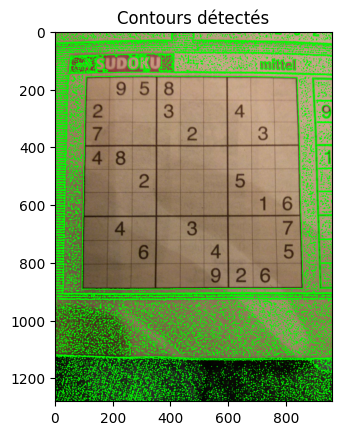

In [347]:
# On crée une copie de l’image couleur pour dessiner par-dessus sans modifier l’originale.
contour_debug = image.copy()
# Détection des contours dans l'image prétraitée.
contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# On dessine les contours détectés sur la copie de l'image.
cv2.drawContours(contour_debug, contours, -1, (0, 255, 0), 2)

plt.figure()
plt.title("Contours détectés")
plt.imshow(cv2.cvtColor(contour_debug, cv2.COLOR_BGR2RGB))
plt.show()


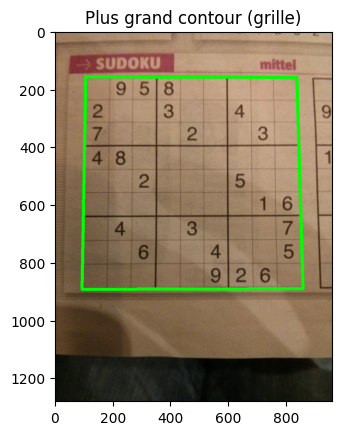

In [348]:

# Fonction pour trouver le plus grand contour qui ressemble à un quadrilatère (comme une grille de sudoku)
def trouver_plus_grand_contour(contours):
    # Stocker le plus grand contour trouvé
    biggest = None
    # mémorise le plus grand contour trouvé jusqu'ici
    max_area = 0
    # Parcourir tous les contours détectés
    for c in contours:
        area = cv2.contourArea(c)
        # On ne garde que les contours dont la surface est significative (plus de 100 pixels)
        if area > 100:
            perimètre = cv2.arcLength(c, True)
            # approx contiendra typiquement 4 points si c’est un rectangle/quadrilatère
            approx = cv2.approxPolyDP(c, 0.02 * perimètre, True)
            if area > max_area and len(approx) == 4:
                # On garde le contour s’il est plus grand que le précédent
                biggest = approx
                max_area = area
    return biggest
biggest = trouver_plus_grand_contour(contours)
contour_red = image.copy()

# Si un contour quadrilatère a été trouvé, on le dessine en vert sur l'image originale
if isinstance(biggest, np.ndarray) and biggest.shape[0] == 4:
    cv2.drawContours(contour_red, [biggest], -1, (0, 255, 0), 10)

    plt.figure()
    plt.title("Plus grand contour (grille)")
    # Convertir l'image en RGB pour l'affichage avec matplotlib
    plt.imshow(cv2.cvtColor(contour_red, cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print("Aucun contour quadrilatère détecté")


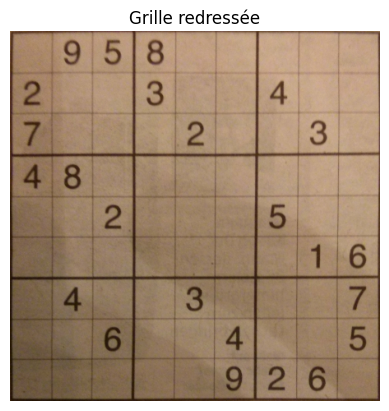

In [349]:
# Fonctione de réorganisation des points du quadrilatère pour les mettre dans l'ordre
def reorder(points):
    # On s'assure que les points sont dans un format approprié
    points = points.reshape((4, 2))
    # On crée un tableau pour les nouveaux points réordonnés
    points_new = np.zeros((4, 1, 2), dtype=np.int32)
    # Calcule la somme et la différence des coordonnées pour identifier les coins
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)] # Coin supérieur gauche
    points_new[3] = points[np.argmax(add)] # Coin inférieur droit
    diff = np.diff(points, axis=1)
    points_new[1] = points[np.argmin(diff)] # Coin supérieur droit
    points_new[2] = points[np.argmax(diff)] # Coin inférieur gauche
    return points_new

# Si on a trouvé un contour quadrilatère, on le réorganise pour la transformation perspective
if biggest is not None and len(biggest) == 4:
    biggest = reorder(biggest)
    pts1 = np.float32(biggest)
    # On définit les points de destination pour la transformation perspective
    pts2 = np.float32([[0, 0], [450, 0], [0, 450], [450, 450]])
    # On crée la matrice de transformation perspective pour redresser la grille
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    # On applique la transformation à l'image
    imagewrap = cv2.warpPerspective(image, matrix, (450, 450))
    # Convertir l'image redressée en RGB pour l'affichage
    imagewrap = cv2.cvtColor(imagewrap, cv2.COLOR_BGR2RGB)

    plt.figure()
    plt.title("Grille redressée")
    plt.imshow(imagewrap)
    plt.axis('off')
    plt.show()
else:
    print("Grille non trouvée pour transformation")


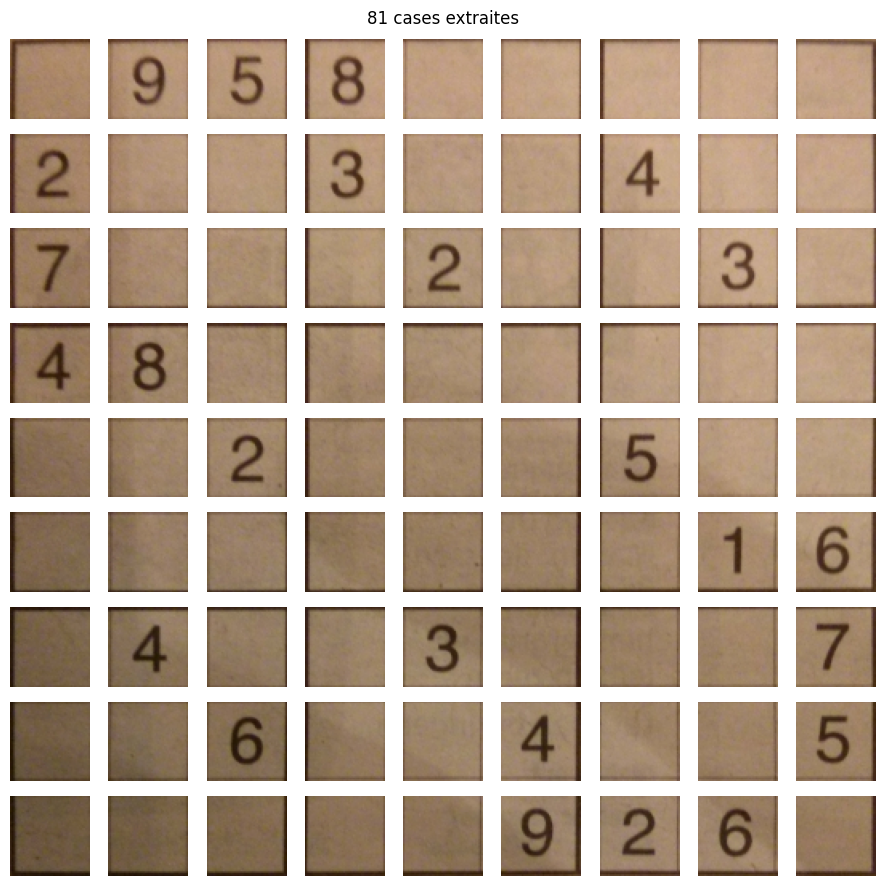

In [352]:
def decouper_grille_en_cases(grille_image):
    # Découpe une grille 450x450 en 81 images 50x50. 
    cases = []
    taille_case = grille_image.shape[0] // 9  # 450 // 9 = 50

    for y in range(9):
        for x in range(9):
            x1 = x * taille_case
            y1 = y * taille_case
            case = grille_image[y1:y1+taille_case, x1:x1+taille_case]
            cases.append(case)
    return cases
cases = decouper_grille_en_cases(imagewrap)

# Affichage des 81 cases
plt.figure(figsize=(9, 9))
for i in range(81):
    plt.subplot(9, 9, i + 1)
    plt.imshow(cases[i], cmap='gray')
    plt.axis('off')
plt.suptitle("81 cases extraites")
plt.tight_layout()
plt.show()

